# 0) Работа с Google Диском

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/'Копия "Проект 18.10 - 29.10"'/

ls: cannot access '/content/drive/MyDrive/Копия "Проект 18.10 - 29.10"/': No such file or directory


# 1) Подключение библиотек

In [ ]:
import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import cv2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# 2) Работа с данными

2.1) Загрузка набора данных и его исследование;

2.2) Подготовка датасета и изображений.

# 2.1) Загрузка набора данных и его изучение

In [ ]:
# пути до нужных файлов
DATADIR_imgs = '/content/drive/MyDrive/Projects_Main/Проект 18.10 - 29.10'
PATH_imgs_info = '/content/drive/MyDrive/Projects_Main/Проект 18.10 - 29.10'

**Загрузка табличного набора данных описывающего изображения.**

In [ ]:
# датасет описывающий изображения букв
dataframe_letters = pd.read_csv(os.path.join(PATH_imgs_info, "all_letters_info.csv"))

In [ ]:
dataframe_letters.head(10)

,letter,label,file,background
0,а,1,01_01.png,0
1,а,1,01_02.png,0
2,а,1,01_03.png,0
3,а,1,01_04.png,0
4,а,1,01_05.png,0
5,а,1,01_06.png,0
6,а,1,01_07.png,0
7,а,1,01_08.png,0
8,а,1,01_09.png,0
9,а,1,01_10.png,0


In [ ]:
dataframe_letters.tail(10)

,letter,label,file,background
14180,я,33,33_421.png,3
14181,я,33,33_422.png,3
14182,я,33,33_423.png,3
14183,я,33,33_424.png,3
14184,я,33,33_425.png,3
14185,я,33,33_426.png,3
14186,я,33,33_427.png,3
14187,я,33,33_428.png,3
14188,я,33,33_429.png,3
14189,я,33,33_430.png,3


**Изучение и Визуализация данных из датасета**

In [ ]:
print(f"В наборе данных {dataframe_letters.shape[0]} строк.")
print(f"И {dataframe_letters.shape[1]} столбца. \n")

print(f"Названия столбцов: {dataframe_letters.columns} \n")

print(f"Процент Null значений в наборе данных:\n{dataframe_letters.isnull().sum() / dataframe_letters.shape[0]}\n")
print(f"Процент NA значений в наборе данных:\n{dataframe_letters.isna().sum() / dataframe_letters.shape[0]}")

В наборе данных 14190 строк.
И 4 столбца. 

Названия столбцов: Index(['letter', 'label', 'file', 'background'], dtype='object') 

Процент Null значений в наборе данных:
letter        0.0
label         0.0
file          0.0
background    0.0
dtype: float64

Процент NA значений в наборе данных:
letter        0.0
label         0.0
file          0.0
background    0.0
dtype: float64


**Визуализация**

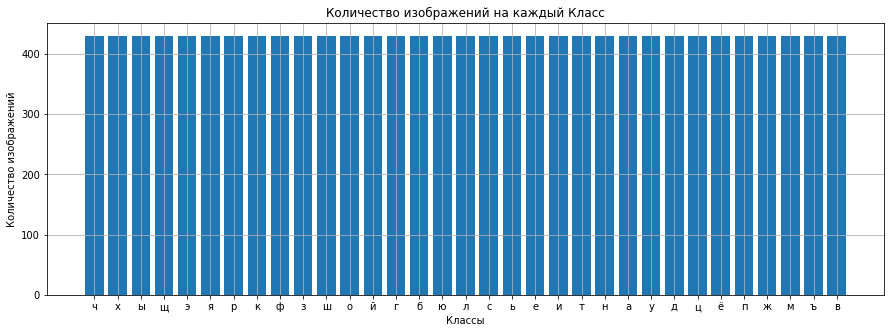

In [ ]:
classes_count = dataframe_letters["letter"].value_counts()

plt.figure(figsize = (15, 5))
plt.bar(classes_count.keys(), classes_count)

plt.grid(True)

plt.title("Количество изображений на каждый Класс")
plt.xlabel("Классы")
plt.ylabel("Количество изображений")

plt.show()

**Словарь, как таблица соотвествий значений столбца "letter" и значений столбца "label". Словарь создаётся для будущей интерпритации результатов Нейронной Сети.**

In [ ]:
values = dataframe_letters["letter"].unique()
nums = range(0, 33)

interpritation_dict = dict(zip(nums, values))
print(values)
interpritation_dict

['а' 'б' 'в' 'г' 'д' 'е' 'ё' 'ж' 'з' 'и' 'й' 'к' 'л' 'м' 'н' 'о' 'п' 'р'
 'с' 'т' 'у' 'ф' 'х' 'ц' 'ч' 'ш' 'щ' 'ъ' 'ы' 'ь' 'э' 'ю' 'я']


{0: 'а',
 1: 'б',
 2: 'в',
 3: 'г',
 4: 'д',
 5: 'е',
 6: 'ё',
 7: 'ж',
 8: 'з',
 9: 'и',
 10: 'й',
 11: 'к',
 12: 'л',
 13: 'м',
 14: 'н',
 15: 'о',
 16: 'п',
 17: 'р',
 18: 'с',
 19: 'т',
 20: 'у',
 21: 'ф',
 22: 'х',
 23: 'ц',
 24: 'ч',
 25: 'ш',
 26: 'щ',
 27: 'ъ',
 28: 'ы',
 29: 'ь',
 30: 'э',
 31: 'ю',
 32: 'я'}

**Загрузка изображений (без предобработки)**

Работа с архивом ZIP

In [ ]:
# загрузка изображений букв
zip_file_1 = zipfile.ZipFile(os.path.join(DATADIR_imgs, "Letters_data/all_letters_image.zip"), "r")
zip_file_1.extractall()
print(os.listdir())

['.config', 'drive', '__MACOSX', 'all_letters_image', 'sample_data']


Функции для загрузки и предварительного показа изображений

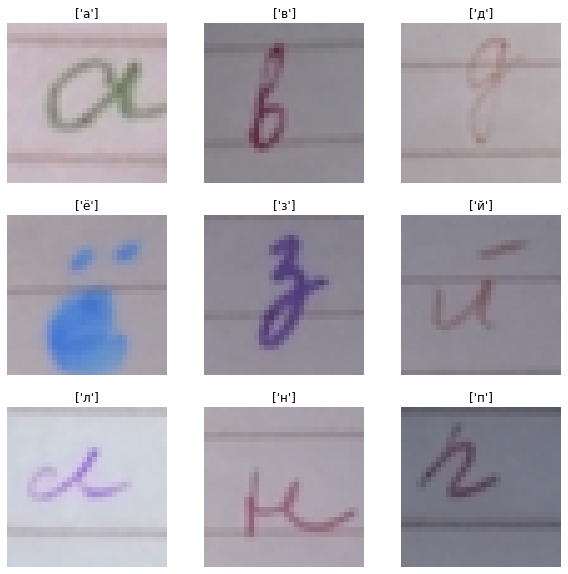

In [ ]:
def letters_image_loader():

  loaded_image_data = []
  loaded_letter_data = []

  for file_name in dataframe_letters["file"].unique():
    path_to_img = f"all_letters_image/{file_name}"
    image = cv2.imread(path_to_img)
    letter = dataframe_letters["letter"][dataframe_letters["file"] == file_name]

    loaded_image_data.append(image)
    loaded_letter_data.append(letter.values)
  
  plt.figure(figsize = (10, 10))
  for n in range(0, 9):
    ax = plt.subplot(3, 3, n + 1)

    plt.imshow(loaded_image_data[n * 100])
    plt.title(loaded_letter_data[n * 100])
    plt.axis("off")

  plt.show()

letters_image_loader()

# 2.2) Обработка данных

2.2.1) Проверка табличных данных на наличие неправильных значений или не нужных столбцов;

2.2.2) Обработка изображений и создание данных для обучения Нейронных Сетей.

# 2.2.1) Проверка табличных данных на наличие неправильных значений или не нужных столбцов 

In [ ]:
# столбец background показывает задний фон изображения, который  для нашей цели работы не принципиален
dataframe_letters = dataframe_letters.drop(columns = ["background"])

# 2.2.2) Обработка изображений и создание данных для обучения Нейронных Сетей

**Обработка изображений**

In [ ]:
!pip install -U albumentations
import albumentations as A

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 47.6 MB 32 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
train_data = []

image_transformer = A.Compose([A.HorizontalFlip(p=0.5),
                               A.RandomBrightnessContrast(p=0.2)])

for file_name in dataframe_letters["file"].unique():
  path_to_img = f"all_letters_image/{file_name}"

  preproccesed_image = cv2.imread(path_to_img, cv2.IMREAD_GRAYSCALE)

  if preproccesed_image.shape != (32, 32):
    preproccesed_image = cv2.resize(preproccesed_image, (32, 32))

  transformed = image_transformer(image = preproccesed_image)
  transformed_image = transformed["image"]
  
  transformed_image = transformed_image / 255
  preproccesed_image = preproccesed_image / 255

  label = dataframe_letters["label"][dataframe_letters["file"] == file_name].values[0]

  train_data.append([torch.FloatTensor(preproccesed_image.reshape((1, 32, 32))), label - 1])
  train_data.append([torch.FloatTensor(transformed_image.reshape((1, 32, 32))), label - 1])

In [ ]:
train_data[1]

[tensor([[[0.7490, 0.7529, 0.7490,  ..., 0.7294, 0.7412, 0.7451],
          [0.7373, 0.7451, 0.7490,  ..., 0.7255, 0.7294, 0.7373],
          [0.6902, 0.6824, 0.6863,  ..., 0.6980, 0.6980, 0.7059],
          ...,
          [0.7451, 0.7529, 0.7333,  ..., 0.7059, 0.6980, 0.6863],
          [0.7490, 0.7451, 0.7451,  ..., 0.7059, 0.7059, 0.7020],
          [0.7451, 0.7451, 0.7490,  ..., 0.7020, 0.7059, 0.7059]]]), 0]

**Создание массивов данных для обучения Нейронных Сетей**

In [ ]:
train_size = int(len(train_data) * 0.8)
test_size = int(len(train_data) * 0.1)
val_size = len(train_data) - train_size - test_size

print(f"Размер тренировочной части данных: {train_size}")
print(f"Размер валидационной части данных: {val_size} \n")
print(f"Размер тестовой части данных: {test_size} \n")

train_data, val_data, test_data = torch.utils.data.random_split(train_data, [train_size, val_size, test_size])

print(f"Проверка на 'существование' тренировочного сета: {type(train_data)}")
print(f"Проверка на 'существование' сета валидации: {type(val_data)}")
print(f"Проверка на 'существование' тестового сета: {type(test_data)}")

Размер тренировочной части данных: 22704
Размер валидационной части данных: 2838 

Размер тестовой части данных: 2838 

Проверка на 'существование' тренировочного сета: <class 'torch.utils.data.dataset.Subset'>
Проверка на 'существование' сета валидации: <class 'torch.utils.data.dataset.Subset'>
Проверка на 'существование' тестового сета: <class 'torch.utils.data.dataset.Subset'>


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

torch.Size([64, 1, 32, 32]) torch.Size([64])


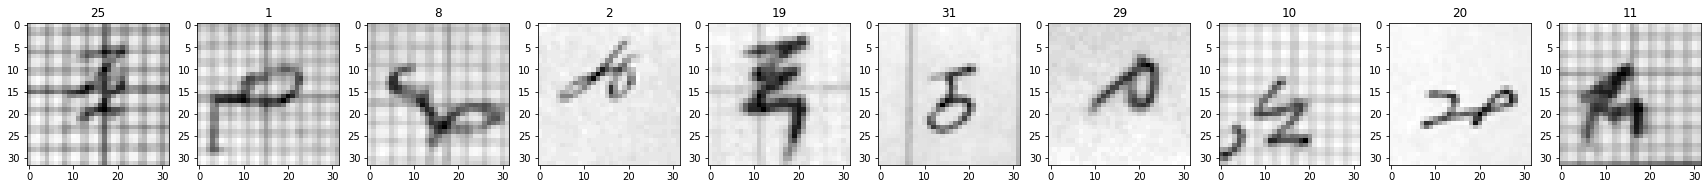

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape, labels.shape)

def show_imgs(imgs, labels):
    f, axes = plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i][0].numpy(), (1, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

# 3) Моделирование

3.1) Создание модели;

3.2) Обучение, тестирование, предсказания

In [ ]:
# проверка на доступность cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

# 3.1) Создание модели и их Сравнение




In [ ]:
# Простая, двуслойная - полносвязная модель
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = torch.nn.Flatten()
        self.fc1 = nn.Linear(32*32*1, 256)
        #self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 33)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = self.fc2(x)
        return x

In [ ]:
# Первая модель
class ConvNet_V1(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (7,7)) #26x26
    # Activation Function (ReLU)
    self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (5, 5)) #22x22
    # Activation Function (ReLU)
    self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3)) #20x20
    self.pool = nn.MaxPool2d(kernel_size = (2, 2)) #10x10
    # Activation Function (ReLU)
    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3)) #8x8
    # Activation Function (ReLU)
    self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3)) #6x6
    # Activation Function (ReLU)
    self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3)) # 4x4
    # Activation Function (ReLU)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(4 * 4 * 256, 256)
    # Sigmoid Function
    self.fc2 = nn.Linear(256, 33)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))

    x = self.flatten(x)
    x = F.sigmoid(self.fc1(x))

    x  = self.fc2(x)
        
    return x

In [ ]:
# Вторая CNN модель
class ConvNet_V2(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (7,7)) #26x26
    # Activation Function (ReLU)
    self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (5, 5)) #22x22
    # Activation Function (ReLU)
    self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3)) #20x20
    self.pool = nn.MaxPool2d(kernel_size = (2, 2)) #10x10
    # Activation Function (ReLU)
    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3)) #8x8
    # Activation Function (ReLU)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 8 * 256, 256)
    # Sigmoid Function
    self.fc2 = nn.Linear(256, 33)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))

    x = self.flatten(x)
    x = F.sigmoid(self.fc1(x))

    x  = self.fc2(x)
        
    return x

In [ ]:
# Первая нейронная сеть (Простая, не сверточная, с двумя, полносвязными слоями)
NN = SimpleNet()
NN = NN.to(device)

In [ ]:
# Первая сверточная нейронная сеть
CNN_v1 = ConvNet_V1()
CNN_v1 = CNN_v1.to(device)

print(f"Архитектура Первой Сверточной Нейронной Сети: \n {CNN_v1}")

Архитектура Первой Сверточной Нейронной Сети: 
 ConvNet_V1(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=33, bias=True)
)


In [ ]:
# Вторая сверточная нейронная сеть
CNN_v2 = ConvNet_V2()
CNN_v2 = CNN_v2.to(device)

print(f"Архитектура Второй Сверточной Нейронной Сети: \n {CNN_v2}")

Архитектура Второй Сверточной Нейронной Сети: 
 ConvNet_V2(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=33, bias=True)
)


# 3.2) Обучение, тестирование, предсказания



 



**Функции для проведения всех операций с моделями**

In [ ]:
# Функция тренировки модели
def train(model, n_epoch=6):
    # функция потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_accuracies = []
    val_losses = []
    
    # обучение сети
    for epoch in tqdm_notebook(range(n_epoch)):
        train_dataiter = iter(train_loader)
        running_loss = 0.0

        model.train(True)
        for i, batch in enumerate(tqdm_notebook(train_dataiter)):
            X_batch, y_batch = batch # текущий batch

            logits = model(X_batch.to(device)) # получение ответов на batch картинок
            loss = loss_fn(logits, y_batch.to(device)) # loss
            loss.backward() # вычисление градиентов
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуление весов
            # текущий loss
            running_loss += loss.item()

            # loss каждые 50 batch`ей
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 49))
                train_losses.append(running_loss / 49)
                running_loss = 0.0

        # evaluate on validation set
        model.train(False)
        val_dataiter = iter(val_loader)

        val_loss_per_epoch = 0
        val_accuracy_per_epoch = 0
        for i, batch in enumerate(tqdm_notebook(val_dataiter)):
            # текущий batch
            X_batch, y_batch = batch
            with torch.no_grad():
                logits = model(X_batch.to(device))
                y_pred = torch.argmax(logits, dim=1)
                val_accuracy_per_epoch += np.mean(y_pred.data.cpu().numpy() == y_batch.numpy())

                val_loss_per_epoch += loss_fn(logits, y_batch.to(device))

        val_accuracies.append(val_accuracy_per_epoch / (i + 1))
        val_losses.append(val_loss_per_epoch.item() / (i + 1))

    print('Обучение закончено')
    return model, train_losses, val_losses, val_accuracies

# Функция визуализации потерь при тренировке модели и валидации
def Train_Val_losses(model, train_losses, val_losses, model_name):

  plt.figure(figsize=(10,6))

  plt.title(f"Потери при тренировке и валидации модели: {model_name}")
  plt.plot(np.arange(len(train_losses)), train_losses, label = "Потеря на тренировке")
  plt.plot(np.arange(1, len(val_losses) + 1) * (len(train_losses) // len(val_losses)), val_losses, label = "Потеря на валидации")

  plt.xlabel("Количество Итераций")
  plt.legend()
  plt.show()

# Функция визуализации точности модели на валидационном сете
def Val_accuracy(val_accuracies, model_name):
  plt.figure(figsize=(10,6))
  plt.title(f"Точность на валидации модели: {model_name}")
  plt.plot(np.arange(len(val_accuracies)), val_accuracies, label='val accuracies')
  plt.xlabel("Количество итераций")
  plt.legend()
  plt.show()
  
# Функция вычисляющая точность модели на тестовом наборе
def evaluate(model, dataloader, name = "Test"):
    accuracy = 0.

    dataiter = iter(dataloader)
    for i, batch in enumerate(tqdm_notebook(dataiter)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        with torch.no_grad():
            logits = model(torch.FloatTensor(X_batch).to(device))
            y_pred = torch.argmax(logits, dim=1)
            accuracy += np.mean(y_pred.data.cpu().numpy() == y_batch.data.cpu().numpy())
    print(f'{name} accuracy is {accuracy / (i + 1)}')
    return accuracy / (i + 1)

**Применение созданных функций на моделях**

***Обучение***

In [ ]:
# обучение простой NN
NN, train_losses_NN, val_losses_NN, val_accuracies_NN = train(NN, n_epoch = 10)

In [ ]:
# обучение первой CNN модели
CNN_v1, train_losses_CNN_v1, val_losses_CNN_v1, val_accuracies_CNN_v1 = train(CNN_v1, n_epoch = 10)

In [ ]:
# обучение второй CNN модели
CNN_v2, train_losses_CNN_v2, val_losses_CNN_v2, val_accuracies_CNN_v2 = train(CNN_v2, n_epoch = 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/355 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,    50] loss: 3.579
[1,   100] loss: 3.521
[1,   150] loss: 3.485
[1,   200] loss: 3.341
[1,   250] loss: 3.075
[1,   300] loss: 2.907
[1,   350] loss: 2.707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[2,    50] loss: 2.498
[2,   100] loss: 2.405
[2,   150] loss: 2.277
[2,   200] loss: 2.211
[2,   250] loss: 2.089
[2,   300] loss: 1.965
[2,   350] loss: 1.915


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[3,    50] loss: 1.706
[3,   100] loss: 1.686
[3,   150] loss: 1.681
[3,   200] loss: 1.531
[3,   250] loss: 1.534
[3,   300] loss: 1.530
[3,   350] loss: 1.443


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[4,    50] loss: 1.250
[4,   100] loss: 1.213
[4,   150] loss: 1.214
[4,   200] loss: 1.154
[4,   250] loss: 1.167
[4,   300] loss: 1.165
[4,   350] loss: 1.107


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[5,    50] loss: 0.934
[5,   100] loss: 0.892
[5,   150] loss: 0.896
[5,   200] loss: 0.870
[5,   250] loss: 0.872
[5,   300] loss: 0.866
[5,   350] loss: 0.847


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[6,    50] loss: 0.676
[6,   100] loss: 0.639
[6,   150] loss: 0.694
[6,   200] loss: 0.669
[6,   250] loss: 0.649
[6,   300] loss: 0.648
[6,   350] loss: 0.659


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[7,    50] loss: 0.496
[7,   100] loss: 0.478
[7,   150] loss: 0.471
[7,   200] loss: 0.461
[7,   250] loss: 0.462
[7,   300] loss: 0.486
[7,   350] loss: 0.461


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[8,    50] loss: 0.311
[8,   100] loss: 0.339
[8,   150] loss: 0.332
[8,   200] loss: 0.357
[8,   250] loss: 0.337
[8,   300] loss: 0.331
[8,   350] loss: 0.347


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[9,    50] loss: 0.229
[9,   100] loss: 0.229
[9,   150] loss: 0.222
[9,   200] loss: 0.221
[9,   250] loss: 0.239
[9,   300] loss: 0.232
[9,   350] loss: 0.258


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

[10,    50] loss: 0.157
[10,   100] loss: 0.138
[10,   150] loss: 0.157
[10,   200] loss: 0.143
[10,   250] loss: 0.156
[10,   300] loss: 0.159
[10,   350] loss: 0.157


  0%|          | 0/45 [00:00<?, ?it/s]

Обучение закончено


***Визуализация результатов***

Результаты простой NN

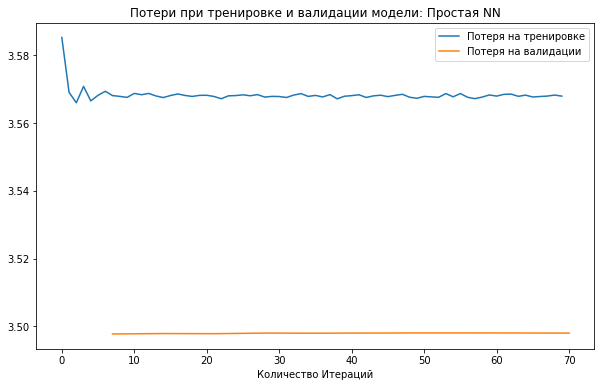

In [ ]:
Train_Val_losses(NN, train_losses_NN, val_losses_NN, "Простая NN")

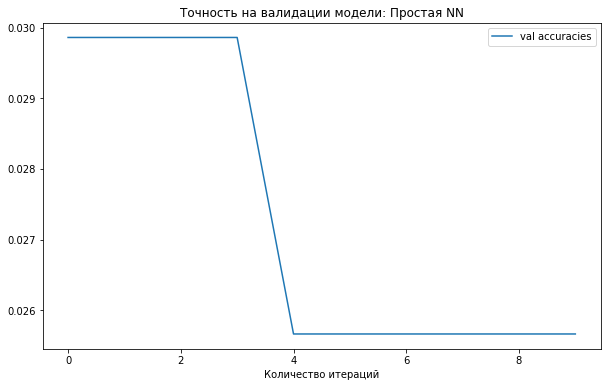

In [ ]:
Val_accuracy(val_accuracies_NN, "Простая NN")

In [ ]:
test_dataiter = iter(test_loader)
evaluate(NN, test_dataiter, name = "Test");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/45 [00:00<?, ?it/s]

Test accuracy is 0.02638888888888889


Результаты первой CNN

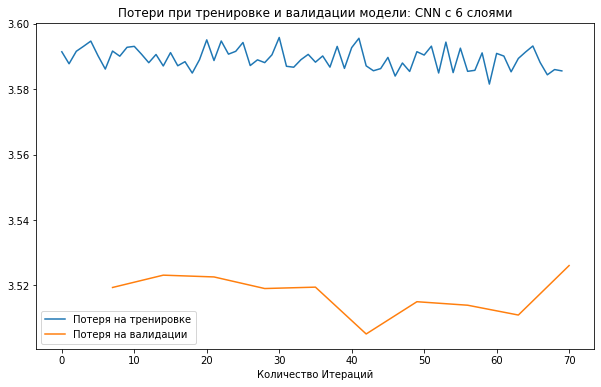

In [ ]:
Train_Val_losses(CNN_v1, train_losses_CNN_v1, val_losses_CNN_v1, "CNN с 6 слоями")

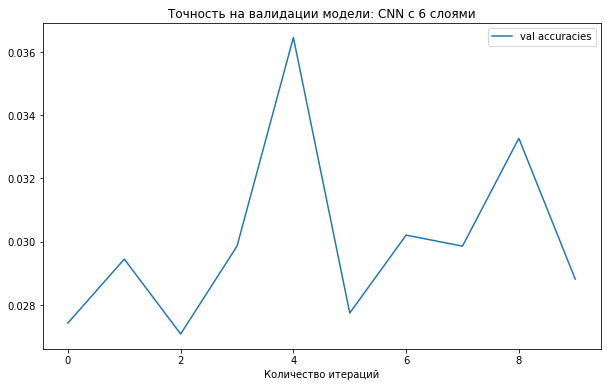

In [ ]:
Val_accuracy(val_accuracies_CNN_v1, "CNN с 6 слоями")

In [ ]:
test_dataiter = iter(test_loader)
evaluate(CNN_v1, test_dataiter, name = "Test");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test accuracy is 0.02736742424242424


Результаты второй CNN

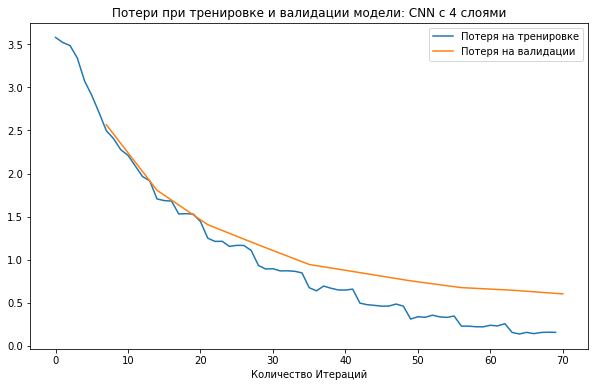

In [ ]:
Train_Val_losses(CNN_v2, train_losses_CNN_v2, val_losses_CNN_v2, "CNN с 4 слоями")

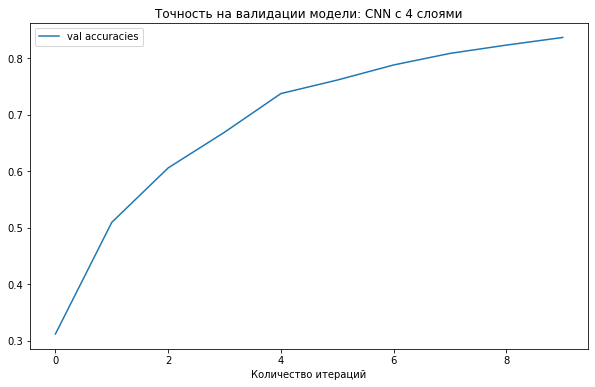

In [ ]:
Val_accuracy(val_accuracies_CNN_v2,  "CNN с 4 слоями")

In [ ]:
test_dataiter = iter(test_loader)
evaluate(CNN_v2, test_dataiter, name = "Test");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test accuracy is 0.8403409090909091


**Лучшая модель, исходя из экспериментов - CNN_v2. Это сверточная нейронная сеть, состоящая из 4 слоёв и слоя пуллинга.**

In [ ]:
from torchsummary import summary

summary(CNN_v2, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]           3,200
            Conv2d-2          [-1, 128, 22, 22]         204,928
            Conv2d-3          [-1, 128, 20, 20]         147,584
         MaxPool2d-4          [-1, 128, 10, 10]               0
            Conv2d-5            [-1, 256, 8, 8]         295,168
           Flatten-6                [-1, 16384]               0
            Linear-7                  [-1, 256]       4,194,560
            Linear-8                   [-1, 33]           8,481
Total params: 4,853,921
Trainable params: 4,853,921
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.54
Params size (MB): 18.52
Estimated Total Size (MB): 20.06
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# сохранение итоговой модели
PATH = PATH_imgs_info
torch.save(CNN_v2.state_dict(), os.path.join(PATH, "main_nn_model"))